In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, BatchNormalization, Conv2D, MaxPool2D, Add, Input, Dropout
print('Tensorflow version =', tf.__version__)

Tensorflow version = 2.0.0-alpha0


## Loading the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
print(f'Training samples = {x_train.shape[0]}')
print(f'Test samples = {x_test.shape[0]}')
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(labels)

Training samples = 50000
Test samples = 10000


## Visualizing some images
 - This is a a classic dataset containing 50000 images belonging to 10 differet categories
 - Our goal here is to perform supervised learning and classify a given image into 10 categories

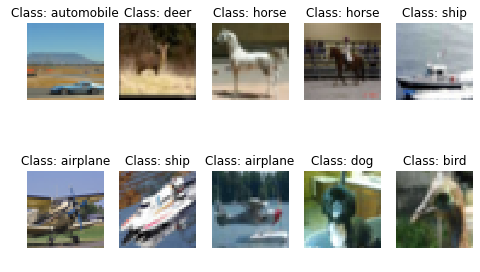

In [3]:
plt.subplots(2, 5, figsize=(8, 5))
for i, idx in enumerate(np.random.randint(0, len(x_train), 10)):
    plt.subplot(2, 5, i+1)
    plt.title(f'Class: {labels[y_train[idx][0]]}')
    plt.axis('off')
    plt.imshow(x_train[idx])

## Mean centering and scaling the dataset

In [7]:
x_test_disp = x_test.copy()
x_train = (x_train - x_train.mean(axis=0))/x_train.std(axis=0)
x_test = (x_test - x_test.mean(axis=0))/x_test.std(axis=0)

## Building the wide residual network using tf.keras
 ### Some points
  - Choosing WRN allows us to achieve better accuracy with a shallow model
  - MirroredStrategy for training to exploit data parallelism

In [4]:
def bn_relu(input_tensor):
    x = BatchNormalization(momentum=1e-1, epsilon=1e-5, gamma_initializer='uniform')(input_tensor)
    x = Activation('relu')(x)
    return x

def x_conv(input_tensor, nfilters, rate=2, strides=1):
    shortcut = Conv2D(filters=nfilters*rate, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_tensor)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_tensor)
    x = bn_relu(x)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Add()([x, shortcut])
    return x

def wide_residual_block(input_tensor, nfilters, rate=2):
    shortcut = input_tensor
    x = bn_relu(input_tensor)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Dropout(0.4)(x)
    x = bn_relu(x)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Add()([x, shortcut])
    return x

def build_wrn():
    input_layer = Input(shape=(32, 32, 3))
    y = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_layer)

    y = bn_relu(y)
    y = x_conv(y, 16)

    for _ in range(4):
        y = wide_residual_block(y, 16)
    y = bn_relu(y)
    y = x_conv(y, 32, strides=2)

    for _ in range(4):
        y = wide_residual_block(y, 32)
    y = bn_relu(y)
    y = x_conv(y, 64, strides=2)

    for _ in range(4):
        y = wide_residual_block(y, 64)
    y = bn_relu(y)
    y = GlobalAveragePooling2D()(y)

    output_layer = Dense(10, activation='softmax')(y)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Using MirroredStrategy to exploit data parallelism across 4 GPU's

In [6]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])
with strategy.scope():
    model = build_wrn()
    plot_model(model, 'model.png', show_shapes=True)
    model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])

## Creating call back objects to help us visualize training and do some trivial tasks like checkpointing, early stopping and training

In [7]:
tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='batch')
callbacks_list = [ModelCheckpoint('model_weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True),
                  tensorboard, EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)]
model.fit(x_train, y_train, epochs=150, batch_size=64, validation_data=(x_test[:9984], y_test[:9984]), callbacks=callbacks_list)

W0404 13:38:47.421691 140488597870400 distributed_training_utils.py:182] Your input callback is not one of the predefined Callbacks that supports DistributionStrategy. You might encounter an error if you access one of the model's attributes as part of the callback since these attributes are not set. You can access each of the individual distributed models using the `_grouped_model` attribute of your original model.
W0404 13:38:47.422427 140488597870400 distributed_training_utils.py:182] Your input callback is not one of the predefined Callbacks that supports DistributionStrategy. You might encounter an error if you access one of the model's attributes as part of the callback since these attributes are not set. You can access each of the individual distributed models using the `_grouped_model` attribute of your original model.
W0404 13:38:47.422858 140488597870400 distributed_training_utils.py:182] Your input callback is not one of the predefined Callbacks that supports DistributionStra

Epoch 1/150
  1/782 [..............................] - ETA: 1:44:30 - loss: 5.2890 - accuracy: 0.0469

W0404 13:40:02.044244 140488597870400 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.111058). Check your callbacks.


780/782 [============================>.] - ETA: 0s - loss: 2.1557 - accuracy: 0.4133
Epoch 00001: val_accuracy improved from -inf to 0.54898, saving model to model_weights.h5
782/782 [==============================] - 79s 101ms/step - loss: 2.1538 - accuracy: 0.4138 - val_loss: 1.5091 - val_accuracy: 0.5490
Epoch 2/150
781/782 [============================>.] - ETA: 0s - loss: 1.2836 - accuracy: 0.6279
Epoch 00002: val_accuracy improved from 0.54898 to 0.64413, saving model to model_weights.h5
782/782 [==============================] - 27s 34ms/step - loss: 1.2835 - accuracy: 0.6279 - val_loss: 1.2428 - val_accuracy: 0.6441
Epoch 3/150
781/782 [============================>.] - ETA: 0s - loss: 1.0667 - accuracy: 0.7042
Epoch 00003: val_accuracy improved from 0.64413 to 0.73147, saving model to model_weights.h5
782/782 [==============================] - 27s 34ms/step - loss: 1.0667 - accuracy: 0.7041 - val_loss: 0.9899 - val_accuracy: 0.7315
Epoch 4/150
781/782 [========================

## Loading the best weights to perform inference

In [5]:
model = build_wrn()
model.load_weights('model_weights.h5')

# Inference loop
 - Use the train dataset mean and std. to preprocess the test images for consistency

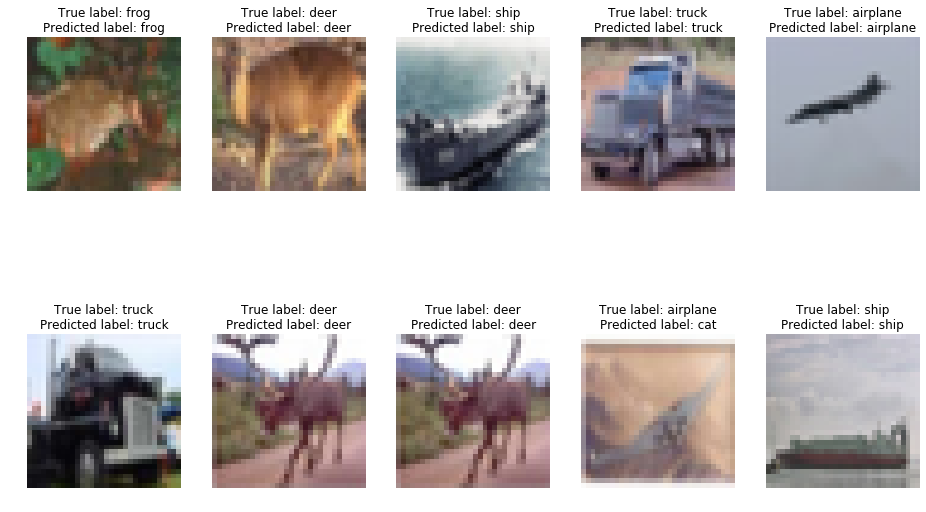

In [8]:
plt.subplots(2, 5, figsize=(16, 10))
for i, idx in enumerate(np.random.randint(0, len(x_test), 10)):
    img = x_test[idx]
    pred_probs = np.squeeze(model.predict(np.expand_dims(img, axis=0)))
    pred = labels[np.argmax(pred_probs)]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(f'True label: {labels[y_test[idx][0]]}\nPredicted label: {pred}', wrap=True)
    plt.imshow(x_test_disp[idx])